
# tSNE!

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import sys
sys.path.append(os.path.realpath(".."))
import tools
import EnergyFlow.ef_tools as ef_tools
import numpy as np

with open("../filepath.txt", 'r') as f:
    filename = f.read().strip("\n")   

# load data
if False: #os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file(filename, njets=10)
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

Using TensorFlow backend.
padding arrays
done padding
777150 events total
444528 events after ensuring first 3 are correctly tagged
307055 events after ensuring we only have 3 tags
303931 events after ensuring there is at most 1 untagged jet


Loading model... 
Using architecture: ../models/architecture_2b.json 
and weights: ../models/weights_2b.h5
303931
100%|██████████| 303931/303931 [00:04<00:00, 65065.99it/s]
overall accuracy: 72.35 percent
ignoring 0.0 percent of 303931 events


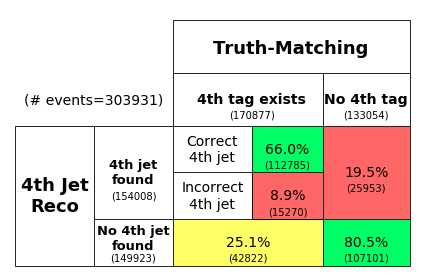

In [2]:
import importlib
import ptetaphi_nn
import awkward
import uproot_methods as urm

importlib.reload(ptetaphi_nn)

events = awkward.Table()
# add data to table
events['resolved_lv'] = urm.TLorentzVectorArray.from_ptetaphie(X[:,:,0], X[:,:,1], X[:,:,2],X[:,:,3])
truths = y[:,:-1].copy().astype(int)
truths[:,:3] = 1 
events['truth'] = truths  # no no-jet jet
tags = X[:,:,4]
events['tag'] = tags

nn = ptetaphi_nn.PtEtaPhiNN(events, load=("../models/architecture_2b.json", "../models/weights_2b.h5"), njets=X.shape[1])

print(len(events))

selections = nn.evaluate(events)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.757s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 49.188046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.298904
[t-SNE] KL divergence after 100000 iterations: 1.570818
(5000, 2)


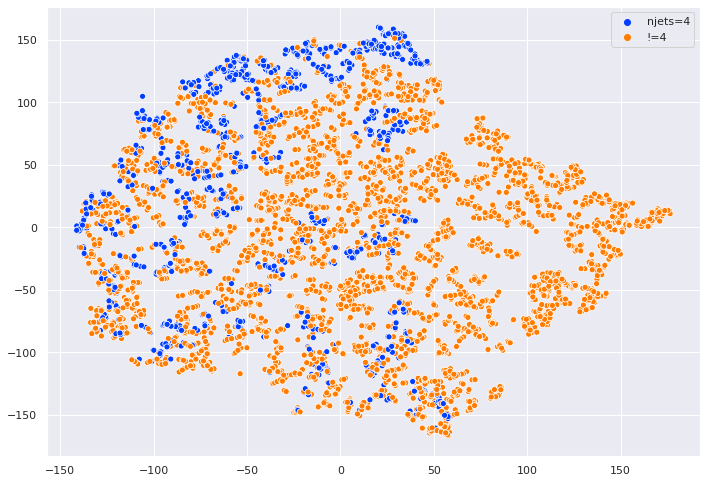

In [3]:
n=5000

import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

tsne = TSNE(perplexity=10, verbose=True, learning_rate=1, n_iter=100000)
# :n so this doesn't take eons
x_2d = np.array([x.flatten() for x in X])[:n, :]


pt = X[:n,:,0]
njets = np.count_nonzero(pt, axis=1)
categories = [0 if n==4 else 1 for n in njets]

X_embedded = tsne.fit_transform(x_2d)
print(X_embedded.shape)


d = {
        0: "njets=4",
        1: "!=4",
    }
cat_words = np.array([d[c] for c in categories])

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cat_words[:n], legend='full', palette=palette)

94


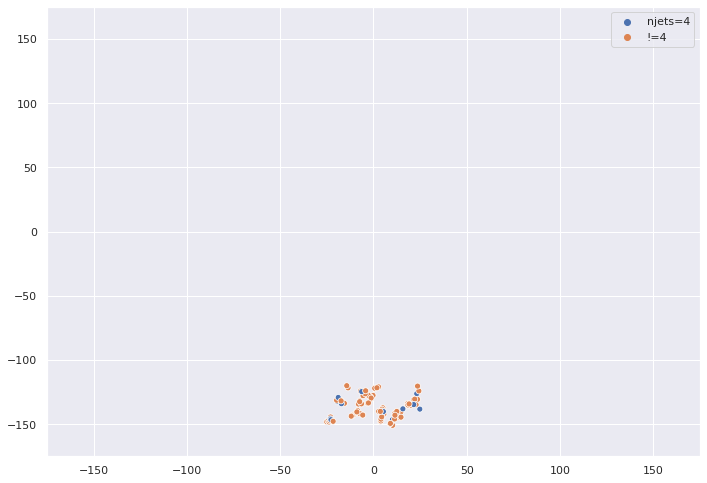

In [27]:
# filter for a bubble:

x = X_embedded[:,0]
y = X_embedded[:,1]

bubble = [True if (-25 < xi and xi < 25 and -175 < yi and yi < -120) else False for xi, yi in zip(x,y)]



sns.scatterplot(x[bubble], y[bubble], hue=cat_words[bubble], legend='full')
plt.xlim(-175, 175)
plt.ylim(-175, 175)

print(len(x[bubble]))

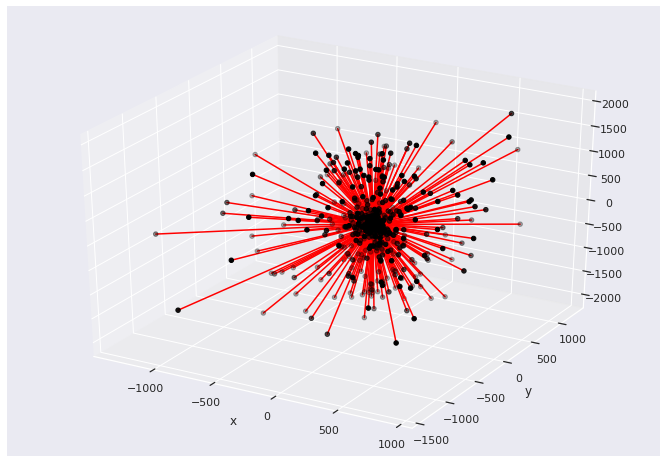

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')        

for i, b in enumerate(bubble):
    if b:
        out_index = i

        vectors = events.resolved_lv

        # plot an event's jets in x y z space
        event_x = vectors.x[out_index]
        event_y = vectors.y[out_index]
        event_z = vectors.z[out_index]

        # plot first couple jets
        for i in range(10):
            ax.plot([0, event_x[i]], [0, event_y[i]], [0, event_z[i]], c='red')

        # plot endpoints as dots
        ax.scatter(event_x, event_y, event_z, c='black')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [29]:
pt = vectors.pt[:n][bubble]
eta = vectors.eta[:n][bubble]
phi = vectors.phi[:n][bubble]
E = vectors.E[:n][bubble]

pt = pt[pt != 0]
eta = eta[eta != 0]
phi = phi[phi != 0]
E = E[E != 0]

94


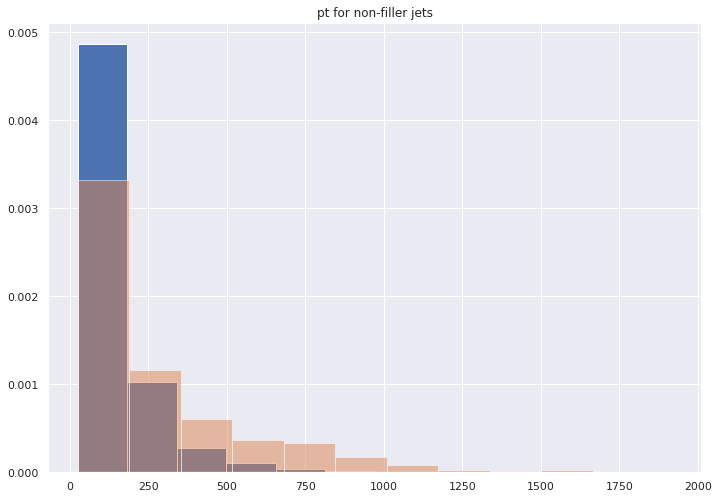

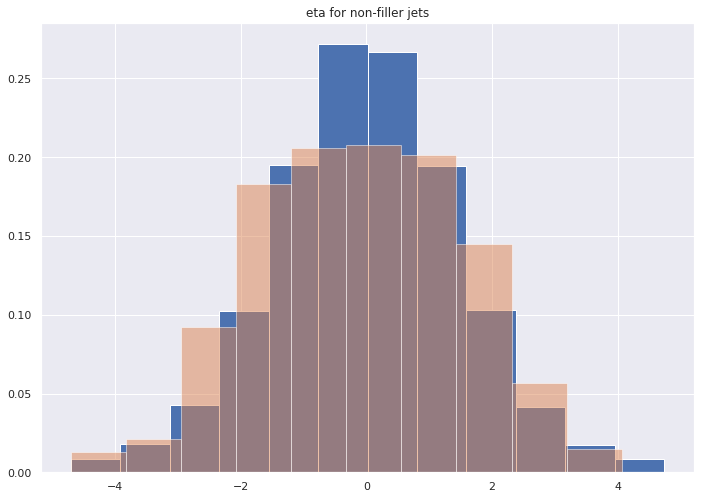

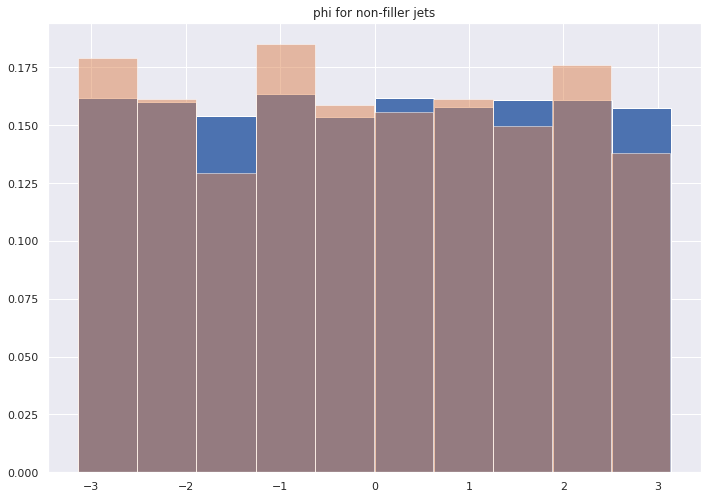

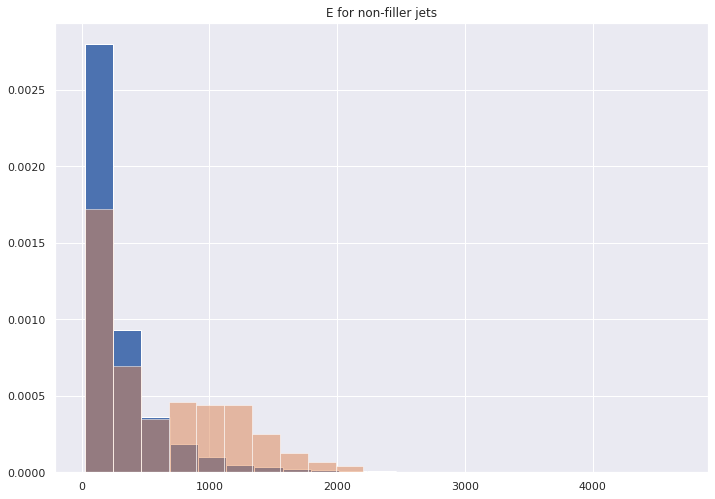

In [32]:
print(len([b for b in bubble if b==True]))
pt_all = vectors.pt[:n]
eta_all = vectors.eta[:n]
phi_all = vectors.phi[:n]
E_all = vectors.E[:n]

pt_all = pt_all[pt_all != 0]
eta_all = eta_all[eta_all != 0]
phi_all = phi_all[phi_all != 0]
E_all = E_all[E_all != 0]

plt.hist(pt_all, density=True, bins=12)
plt.hist(pt, density=True, bins=10, alpha=0.5)
plt.title("pt for non-filler jets")
plt.savefig('pt_comp_all.png')
plt.show()
plt.hist(eta_all, density=True, bins=12)
plt.hist(eta, density=True, bins=10, alpha=0.5)
plt.title("eta for non-filler jets")
plt.savefig('eta_comp_all.png')
plt.show()
plt.hist(phi_all, density=True, bins=10)
plt.hist(phi, density=True, bins=10, alpha=0.5)
plt.title("phi for non-filler jets")
plt.savefig('phi_comp_all.png')
plt.show()
plt.hist(E_all, density=True, bins=21)
plt.hist(E, density=True, bins=10, alpha=0.5)
plt.title("E for non-filler jets")
plt.savefig('E_comp_all.png')
plt.show()




(5000,)
5000
(94,)


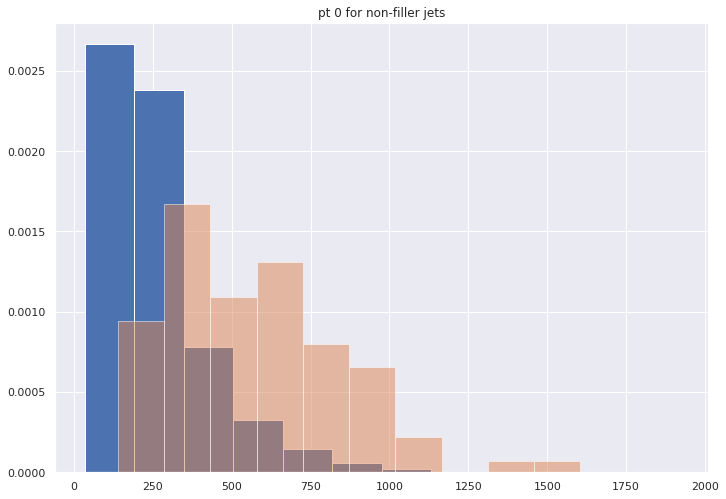

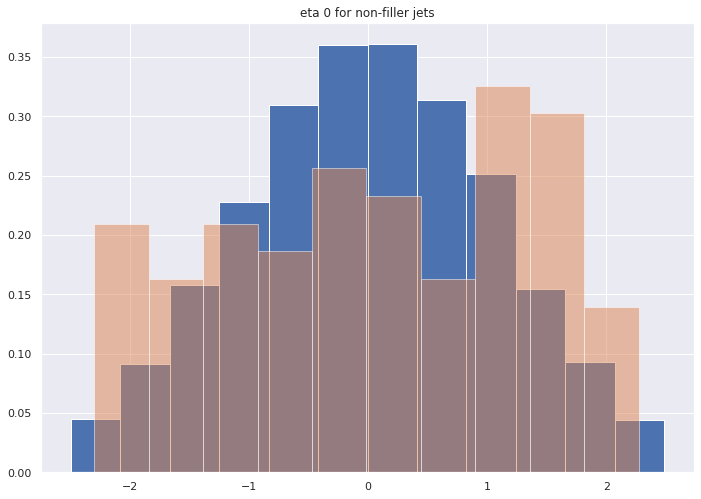

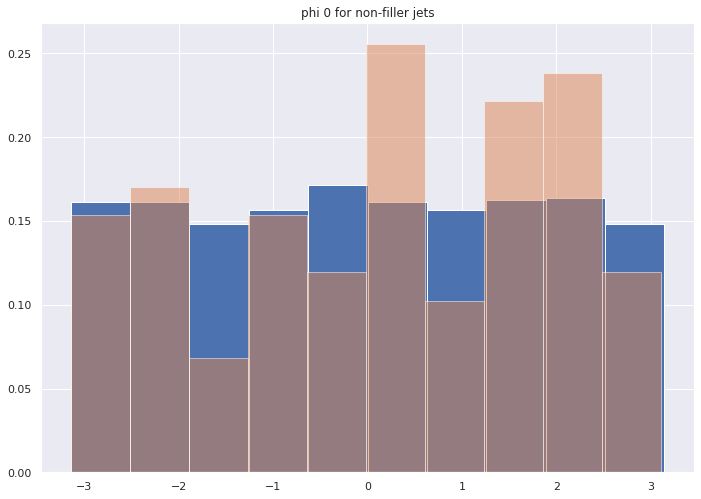

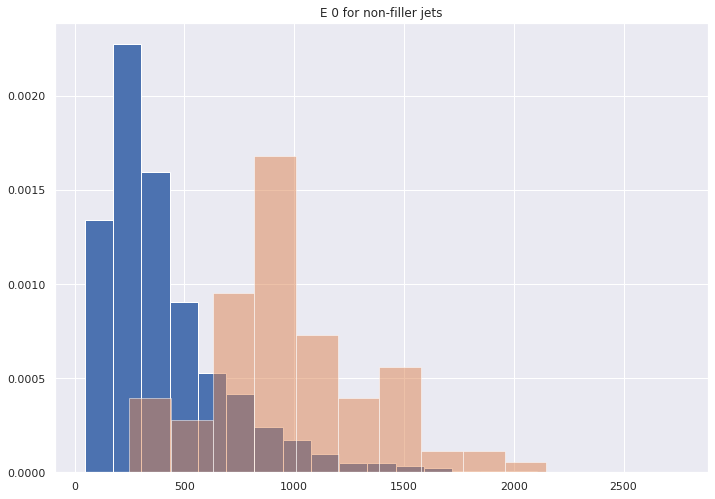

(5000,)
5000
(94,)


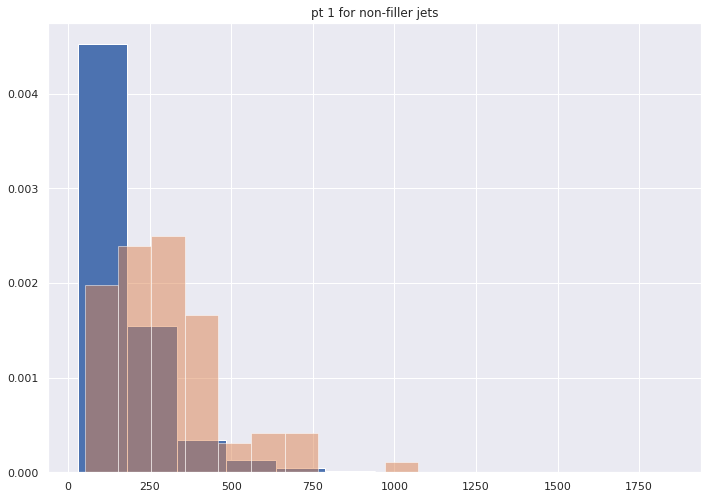

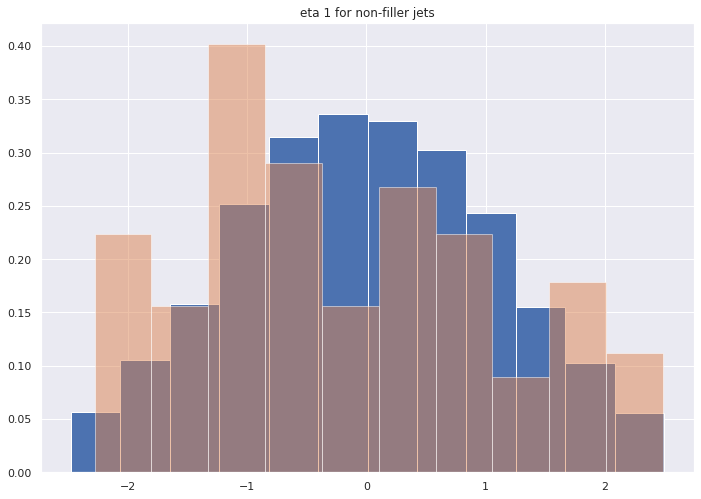

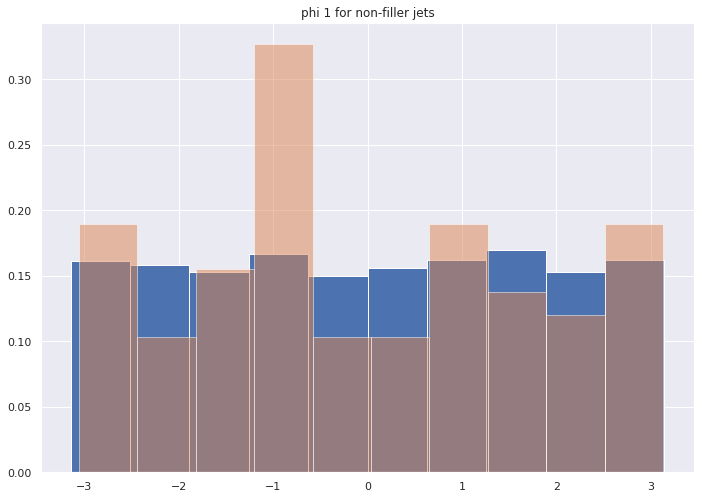

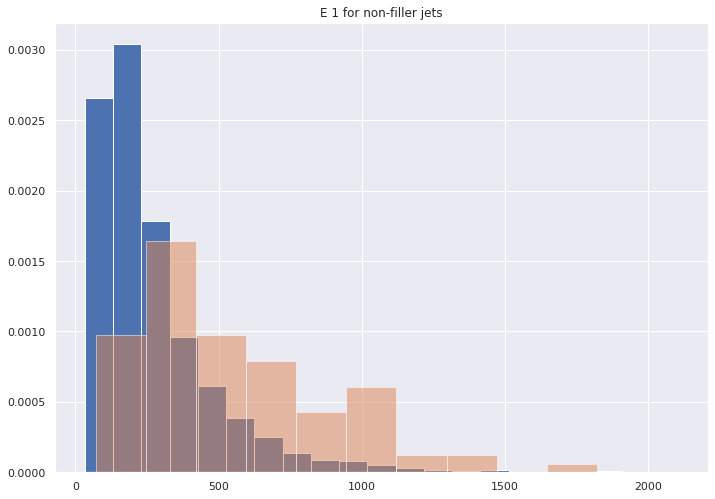

(5000,)
5000
(94,)


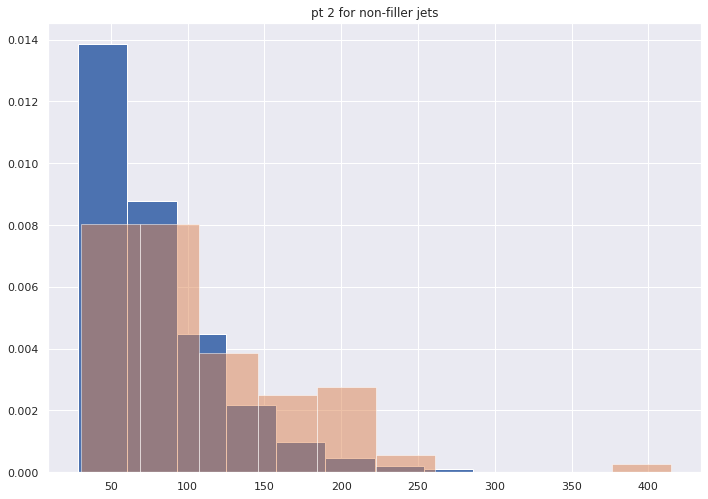

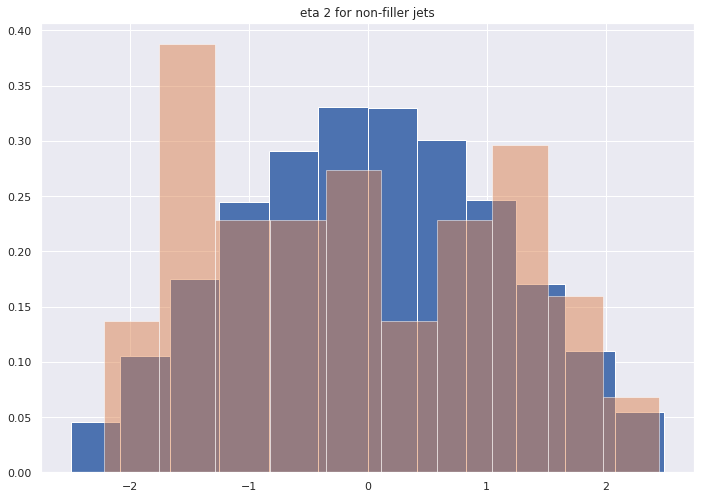

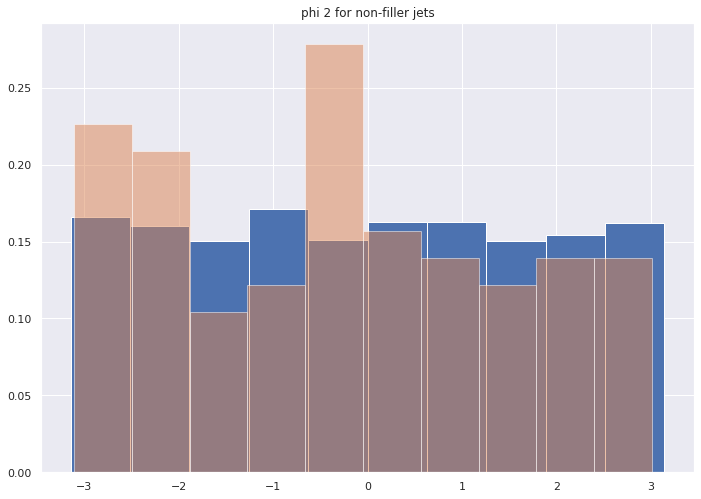

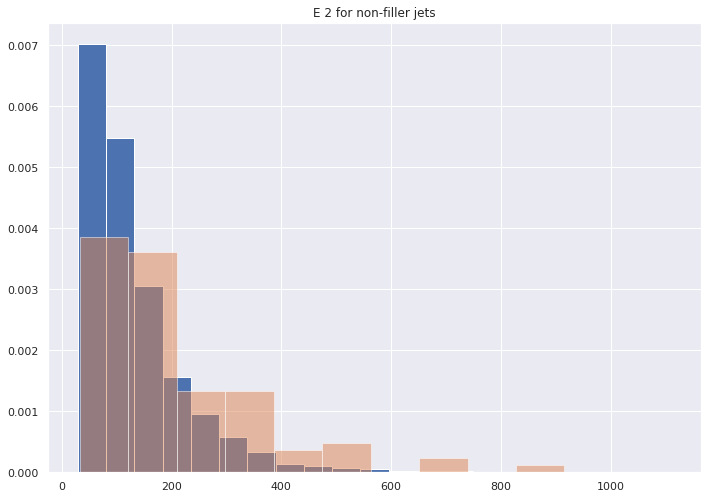

(4981,)
5000
(94,)


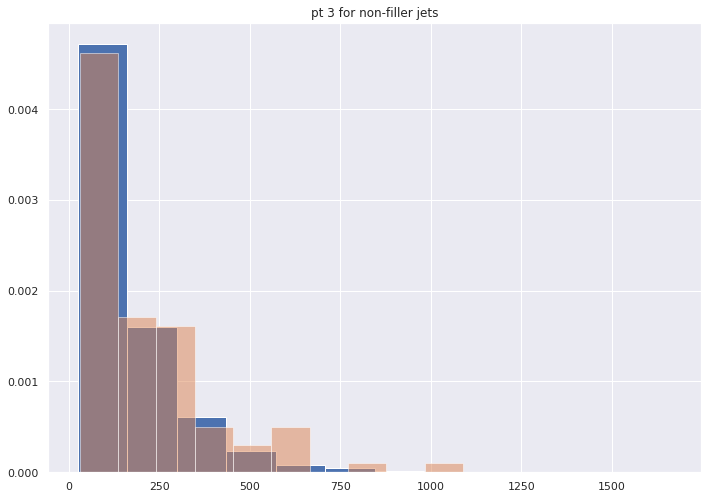

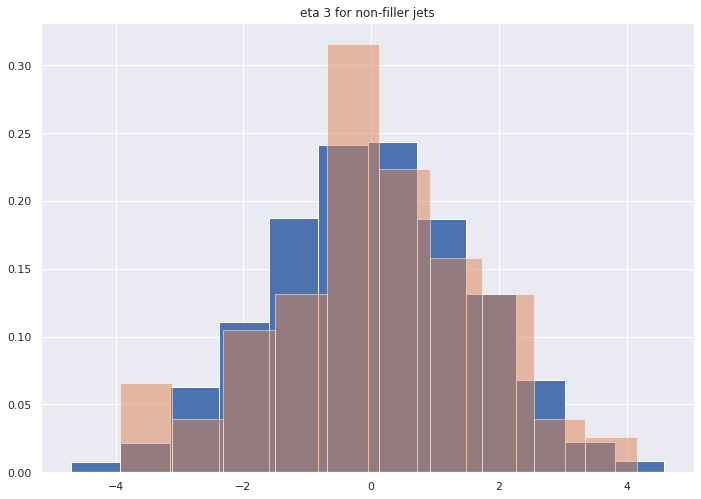

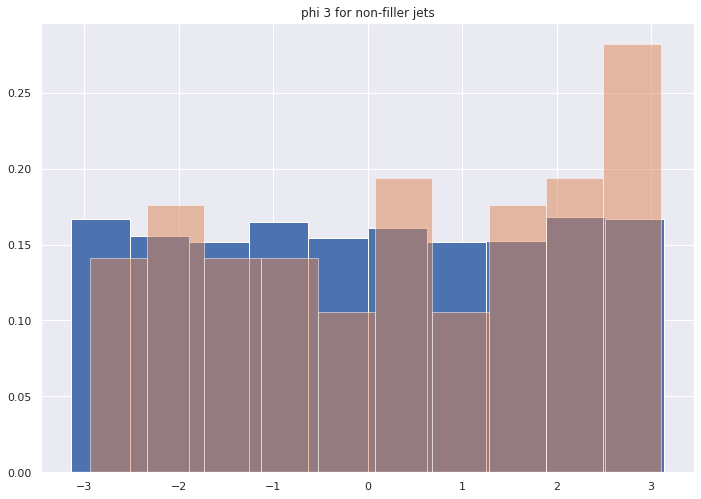

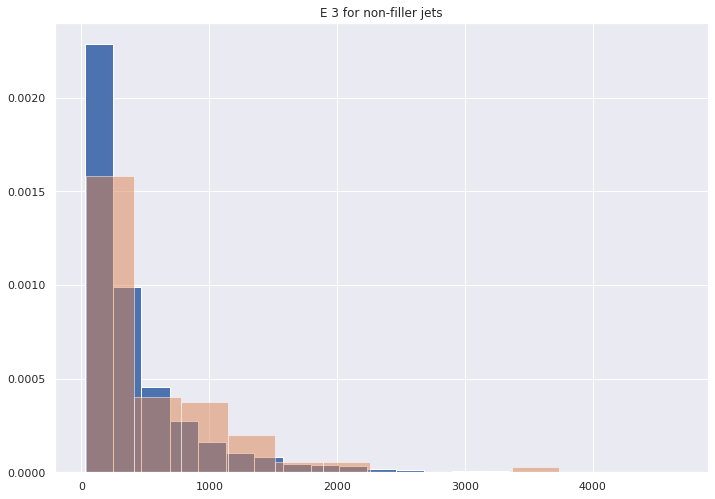

(3856,)
5000
(78,)


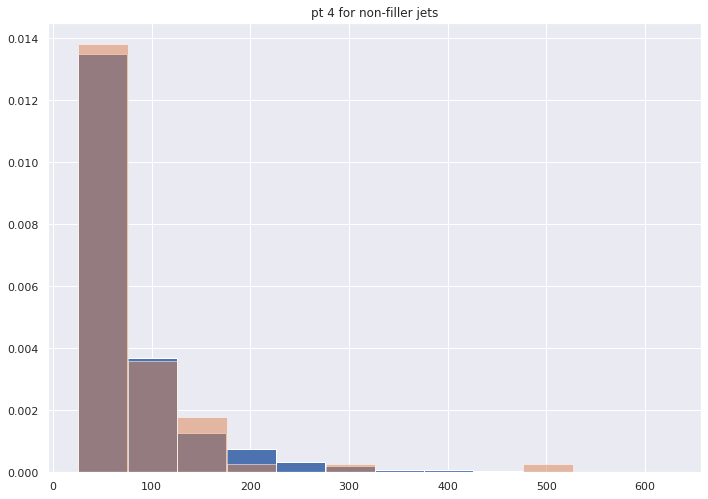

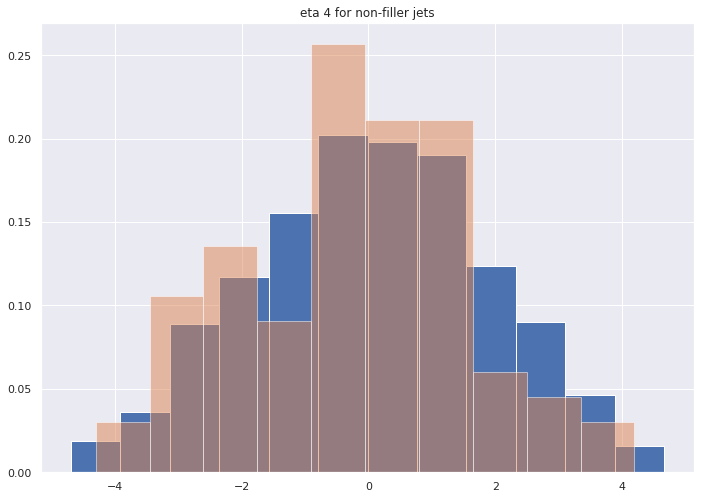

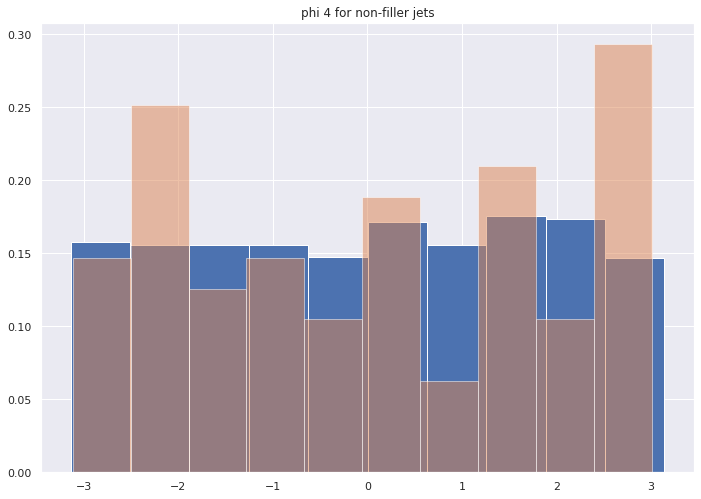

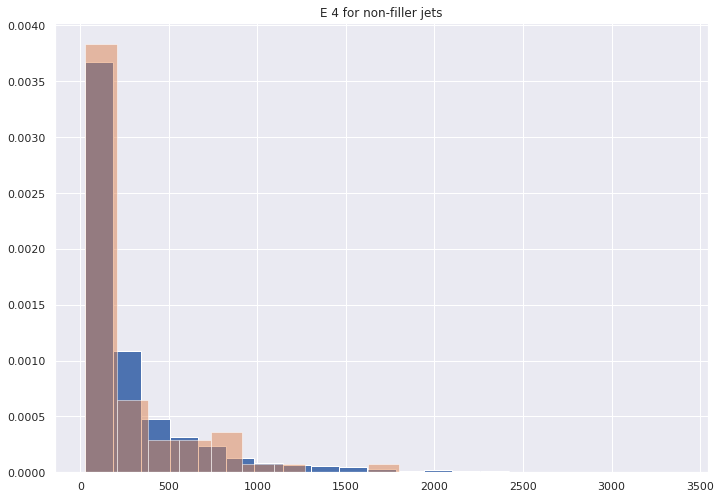

(2460,)
5000
(52,)


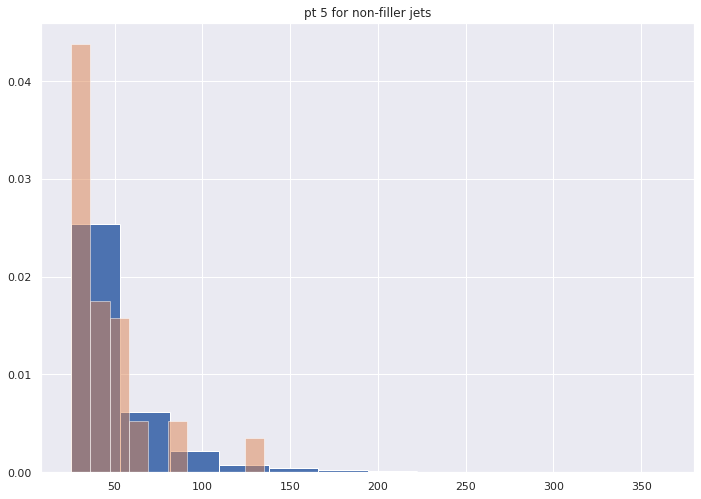

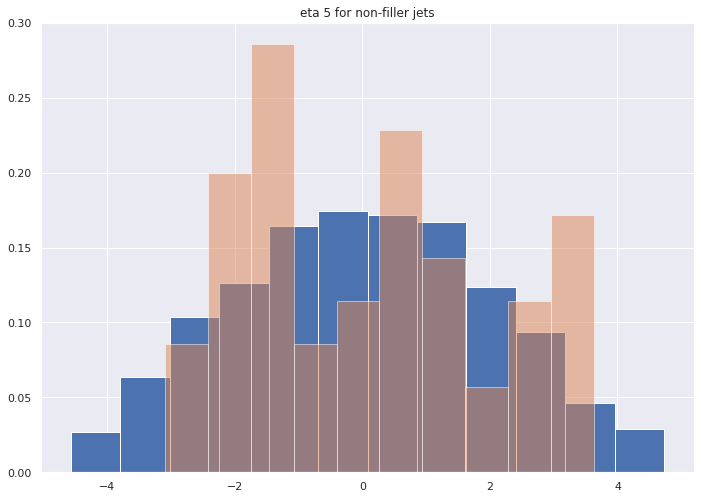

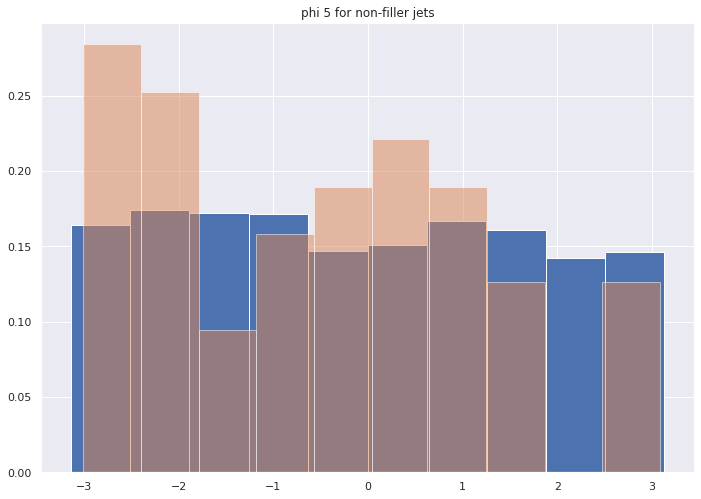

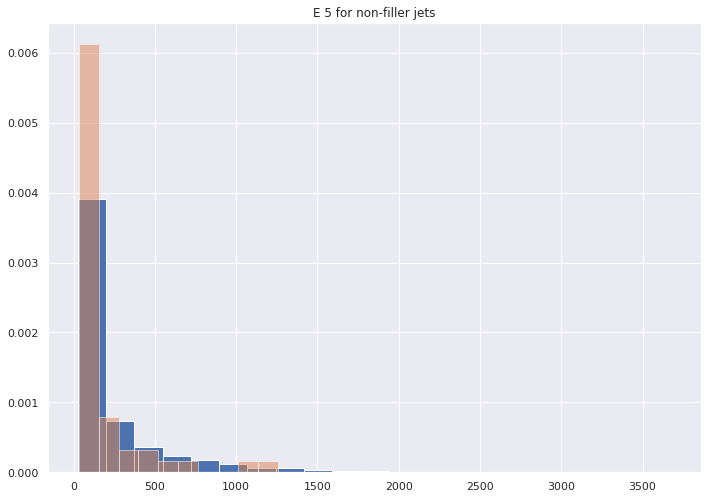

(1271,)
5000
(23,)


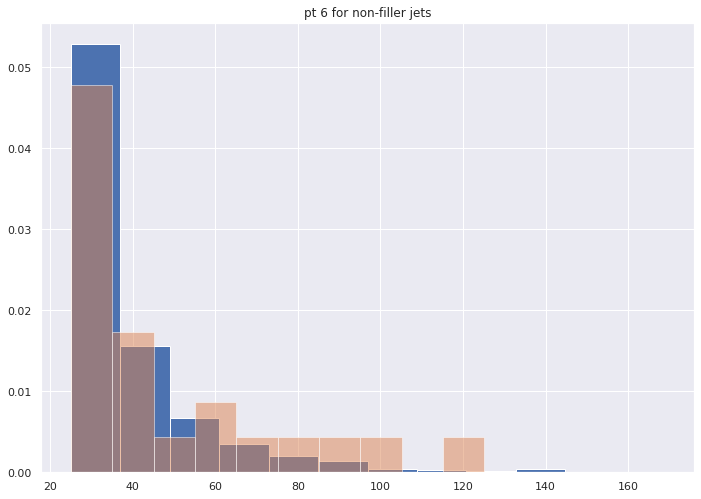

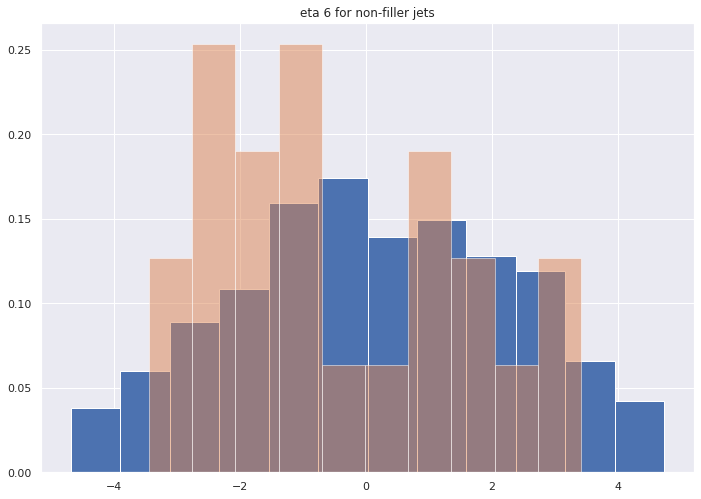

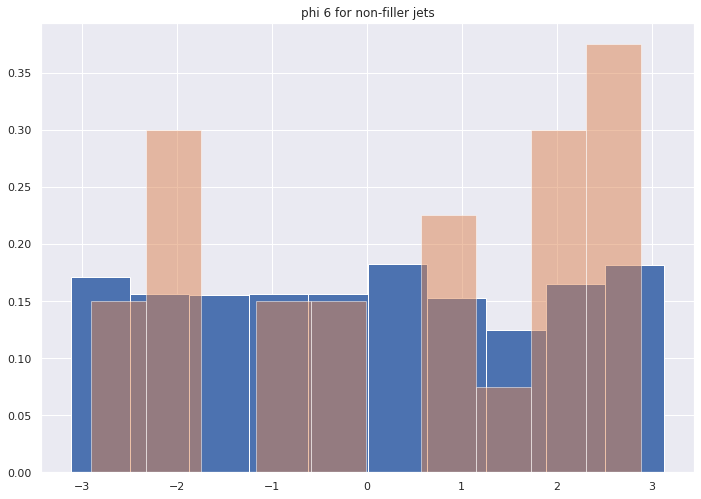

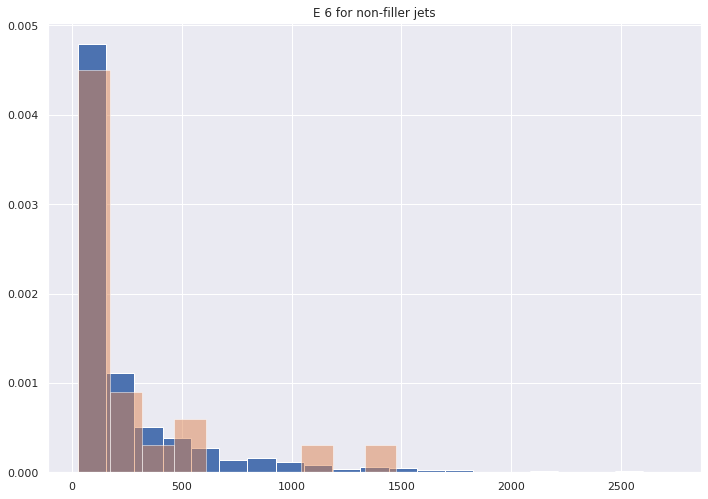

(483,)
5000
(10,)


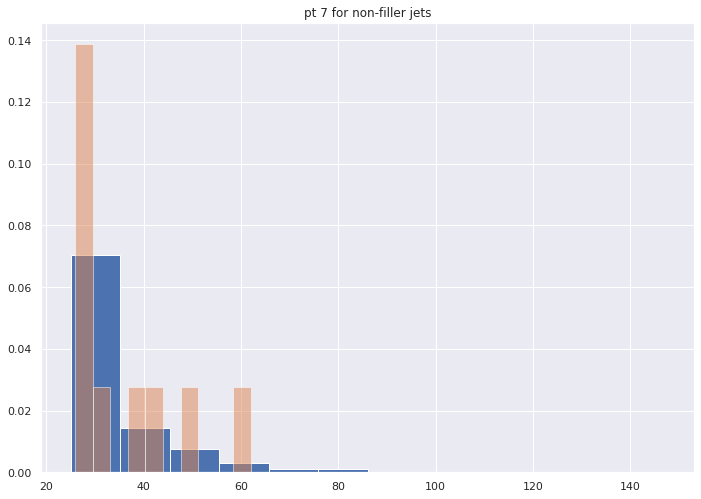

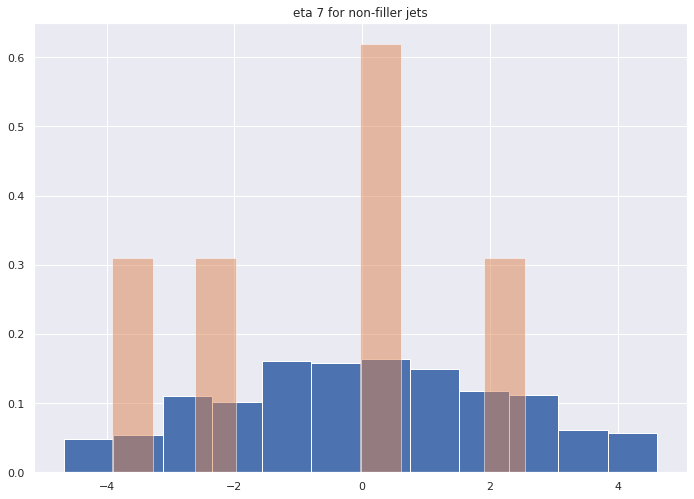

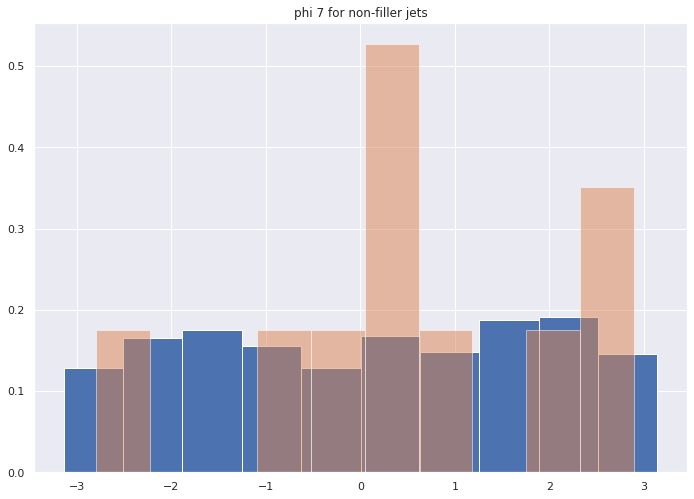

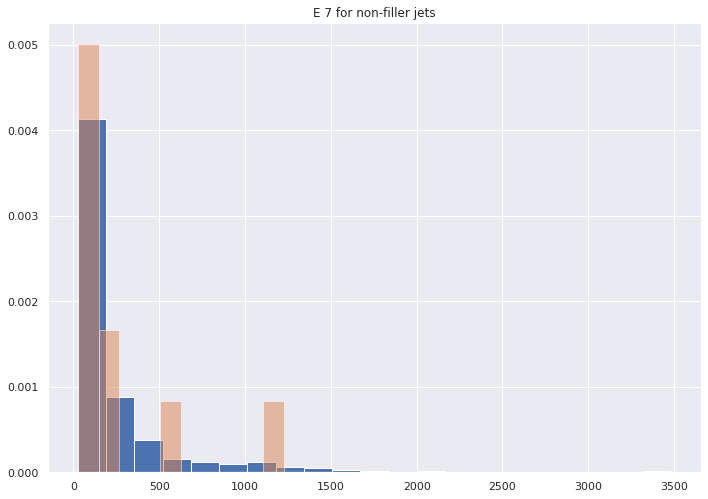

In [40]:
# pt = in bubble, pt_all = not necessarily

for i in range(8):
    pt_all_i = vectors.pt[:n,i]
    eta_all_i = vectors.eta[:n,i]
    phi_all_i = vectors.phi[:n,i]
    E_all_i = vectors.E[:n,i]
    
    pt_all_i = pt_all_i[pt_all_i != 0]
    eta_all_i = eta_all_i[eta_all_i != 0]
    phi_all_i = phi_all_i[phi_all_i != 0]
    E_all_i = E_all_i[E_all_i != 0]

    print(pt_all_i.shape)
    print(len(bubble))

    pt_i = pt_all_i[bubble[:len(pt_all_i)]]
    eta_i = eta_all_i[bubble[:len(pt_all_i)]]
    phi_i = phi_all_i[bubble[:len(pt_all_i)]]
    E_i = E_all_i[bubble[:len(pt_all_i)]]
    print(pt_i.shape)


    plt.hist(pt_all_i, density=True, bins=12)
    plt.hist(pt_i, density=True, bins=10, alpha=0.5)
    plt.title(f"pt {i} for non-filler jets")
    plt.savefig(f'pt_comp_{i}.png', transparent=True)
    plt.show()
    plt.hist(eta_all_i, density=True, bins=12)
    plt.hist(eta_i, density=True, bins=10, alpha=0.5)
    plt.title(f"eta {i} for non-filler jets")
    plt.savefig(f'eta_comp_{i}.png', transparent=True)
    plt.show()
    plt.hist(phi_all_i, density=True, bins=10)
    plt.hist(phi_i, density=True, bins=10, alpha=0.5)
    plt.title(f"phi {i} for non-filler jets")
    plt.savefig(f'phi_comp_{i}.png', transparent=True)
    plt.show()
    plt.hist(E_all_i, density=True, bins=21)
    plt.hist(E_i, density=True, bins=10, alpha=0.5)
    plt.title(f"E {i} for non-filler jets")
    plt.savefig(f'E_comp_{i}.png', transparent=True)
    plt.show()
    

